In [70]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne_nirs.statistics import statsmodels_to_results

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl
from mne.stats import fdr_correction


# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [71]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 50

# Time from trigger point being evaluated
tmin = -1
tmax = 50

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = False





In [72]:
# # FV Study Parameters
# ignore = [".DS_Store", ".git", "sub-18", "sub-14", ".gitignore"]
# columns_for_group_analysis = ['Neutral', 'Concern']
# columns_for_glm_contrast = ['Neutral', 'Concern']
# path = '../../FV_Prelim_Data/'
# trigger_id = {'1': 'Start', '2': 'Neutral', '3': 'Concern'}
# columns_for_fdr = ['Neutral', 'Concern']

In [73]:
# # FA Study Parameters
# columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']
# columns_for_glm_contrast = ['Neutral', 'Inflam', 'Control']
# columns_for_fdr = ['Control', 'Inflam']
# path = "../../LabResearch/IndependentStudy/Data/FA"
# ignore = [".DS_Store", "sub-03", ".git", ".gitignore"]
# trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

In [74]:
# Oculus Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/oculus_montage_bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [75]:
# N-Back Control Montage Parameters
# columns_for_group_analysis = ['oneBack', 'twoBack', 'threeBack']
# columns_for_glm_contrast = ['oneBack', 'twoBack', 'threeBack']
# path = '../../../Desktop/n-back-bids/'
# ignore = [".DS_Store", ".git", ".gitignore"]
# trigger_id = {'1': 'oneBack', '2': 'twoBack', '3': 'threeBack'}

In [76]:
# Live Drive
ignore = [".DS_Store", ".git", "sub-01", ".gitignore"]
columns_for_group_analysis = ['Driving']
columns_for_glm_contrast = ['Driving']
path = '../../LiveDrive'
trigger_id = {'2': 'Driving'}
columns_for_fdr = ['Driving']

In [77]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time, tmin=tmin, tmax=tmax)
        
        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        print("GLM Data Processed ---> Calcuating GLM Dataframe")
        
        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        raw_haemo = all_data[0]['raw_haemo']
        
        print("GLM Dataframe Generated. Finding all significant channels")
        # Find the groups significant channels
        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [78]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None, trigger_id=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data, all_evokeds = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)
        
        raw_haemo = all_data[0]['raw_haemo']

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con, glm_results = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        ch_model_df = analysis_tools.create_results_dataframe(df_cha, columns_for_glm_contrast, raw_haemo)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(ch_model_df)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes, all_epochs, all_evokeds, glm_results

In [79]:
importlib.reload(glm_analysis)
group_data, all_epochs, all_evokeds, glm_results = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax, trigger_id=trigger_id)

print(glm_results)


Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LiveDrive/All/sub-02/nirs/2023-04-19_002.snirf
Reading 0 ... 10895  =      0.000 ...  1070.978 secs...
{'2': 'Driving'}
[[ 33   0   1]
 [ 81   0   1]
 [129   0   1]
 [177   0   1]
 [225   0   1]
 [273   0   1]
 [321   0   1]
 [369   0   1]
 [417   0   1]
 [465   0   1]] {'Driving': 1}
sub_id 2
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LiveDrive/All/sub-03/nirs/2023-04-19_003.snirf
Reading 0 ... 11166  =      0.000 ...  1097.618 secs...
{'2': 'Driving'}
[[133   0   1]
 [181   0   1]
 [229   0   1]
 [277   0   1]
 [325   0   1]
 [373   0   1]
 [421   0   1]
 [469   0   1]
 [517   0   1]
 [565   0   1]
 [652   0   1]] {'Driving': 1}
sub_id 3
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LiveDrive/All/sub-04/nirs/2023-04-19_004.snirf


/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/quality_eval.py:54: RuntimeWarning: Negative intensities encountered. Setting to abs(x)
  raw_od = optical_density(raw_intensity)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:67: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  all_evokeds[condition].append(epoch[condition].average())


Reading 0 ... 10997  =      0.000 ...  1081.005 secs...
{'2': 'Driving'}
[[ 37   0   1]
 [ 85   0   1]
 [133   0   1]
 [181   0   1]
 [229   0   1]
 [277   0   1]
 [325   0   1]
 [373   0   1]
 [421   0   1]
 [469   0   1]] {'Driving': 1}
sub_id 4
EVENTS
{'Driving': 1}
[[ 37   0   1]
 [ 85   0   1]
 [133   0   1]
 [181   0   1]
 [229   0   1]
 [277   0   1]
 [325   0   1]
 [373   0   1]
 [421   0   1]
 [469   0   1]]
GLM Event Dict {'Driving': 1}
Event [465   0   1] 50
GLM Event Dict {'Driving': 1}
Event [652   0   1] 50
GLM Event Dict {'Driving': 1}
Event [469   0   1] 50
GLM Data Processed ---> Calcuating GLM Dataframe


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:67: RuntimeWarning: evoked object is empty (based on less than 1 epoch)
  all_evokeds[condition].append(epoch[condition].average())


Columns in Design matrix Index(['Driving', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5',
       'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11',
       'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17',
       'drift_18', 'drift_19', 'drift_20', 'drift_21', 'constant'],
      dtype='object')


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


Columns in Design matrix Index(['Driving', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5',
       'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11',
       'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17',
       'drift_18', 'drift_19', 'drift_20', 'drift_21', 'constant'],
      dtype='object')


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)


Columns in Design matrix Index(['Driving', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'drift_5',
       'drift_6', 'drift_7', 'drift_8', 'drift_9', 'drift_10', 'drift_11',
       'drift_12', 'drift_13', 'drift_14', 'drift_15', 'drift_16', 'drift_17',
       'drift_18', 'drift_19', 'drift_20', 'drift_21', 'constant'],
      dtype='object')
GLM Dataframe Generated. Finding all significant channels


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


GLM Results for 36 channels


/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df)
/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/analysis_tools.py:300: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sig_channels = all_sig_channels.append(sig_df

In [80]:
# individual_data, all_epochs, all_evokeds = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, trigger_id)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


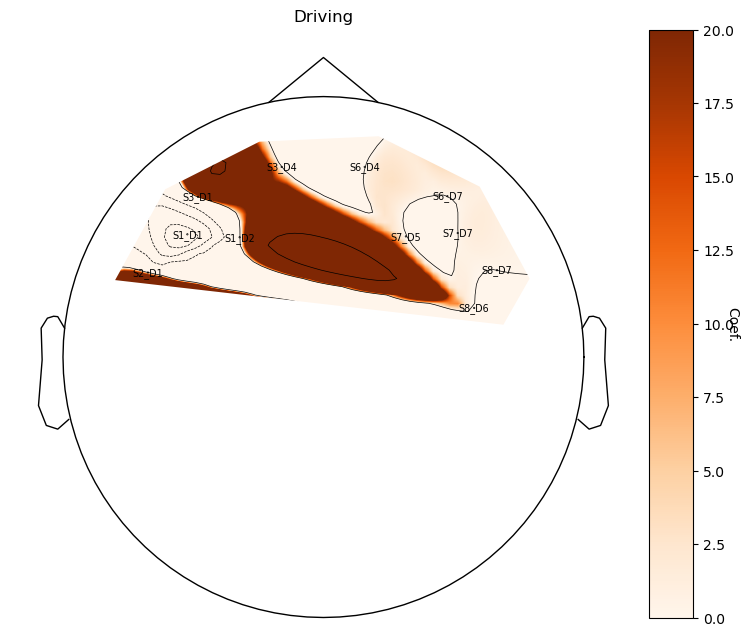

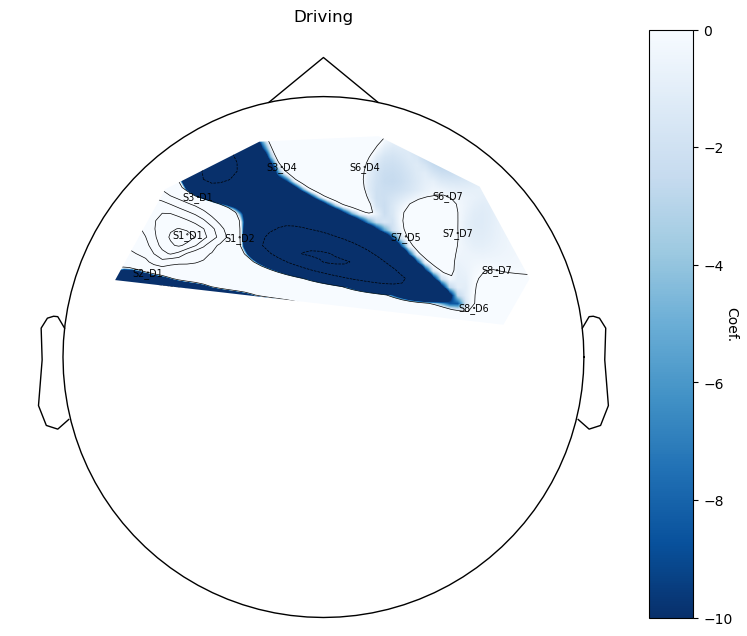

In [81]:
# Group Visualization
importlib.reload(visualizations)
groups = list(group_data.keys())
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()
    raw_haemo = all_data[0]['raw_haemo']
    visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo, group)

In [82]:
# Group Visualization with FDR Correction
importlib.reload(visualizations)
importlib.reload(analysis_tools)
ignored_vals = ['drift', 'Start', 'constant']

groups = list(group_data.keys())
results = {}
for group in groups:
    # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
    channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

    channels_df_fdr = analysis_tools.false_discovery_rate_correction(channels_df, ignored_vals, columns_for_fdr)

    raw_haemo = all_data[0]['raw_haemo']

    alpha = 0.05
    p_vals = channels_df['p_value']
    reject_fdr, pval_fdr = fdr_correction(p_vals, alpha=alpha, method='indep')
    channels_df['fdr_status'] = reject_fdr
    channels_df_fdr = channels_df.loc[(channels_df['fdr_status'] == True) & (~channels_df['Condition'].isin(ignored_vals))]
    channels_df_fdr = channels_df_fdr.drop_duplicates()
    print(channels_df)
    
    # channels_df_fdr.to_csv('channels_df_fdr.csv')
    # visualizations.group_topological_visualisation(channels_df_fdr, columns_for_glm_contrast, raw_haemo, group)

variable Condition    df           mse   p_value        se         t  \
0          Driving  23.0  9.574245e-10  0.646565  0.000009  0.464630   
1         constant  23.0  9.574245e-10  0.765187  0.000006 -0.302238   
2          drift_1  23.0  9.574245e-10  0.841801  0.000149 -0.201860   
3         drift_10  23.0  9.574245e-10  0.896314  0.000122 -0.131768   
4         drift_11  23.0  9.574245e-10  0.997027  0.000121  0.003767   
...            ...   ...           ...       ...       ...       ...   
2479       drift_5  23.0  1.738925e-12  0.993326  0.000008  0.008456   
2480       drift_6  23.0  1.738925e-12  0.796789  0.000008 -0.260509   
2481       drift_7  23.0  1.738925e-12  0.988934  0.000008 -0.014021   
2482       drift_8  23.0  1.738925e-12  0.962881  0.000008 -0.047048   
2483       drift_9  23.0  1.738925e-12  0.914042  0.000008 -0.109135   

variable         theta Source Detector Chroma  Significant    ch_name  ID  \
0         4.263222e-06      1        1    hbo        False

In [83]:
# # Group Cortical Projections
# importlib.reload(visualizations)
# groups = list(group_data.keys())
# for group in groups:
#     # channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()
#     channels_df, contrasts_df, significant_channels, all_data = group_data[group].values()

#     raw_haemo = all_data[0]['raw_haemo']
#     visualizations.group_cortical_surface_projection(channels_df, columns_for_glm_contrast, raw_haemo, path)

In [84]:
importlib.reload(visualizations)
visualizations.plot_waveform_analysis(all_evokeds, variable_epoch_time)

TypeError: plot_waveform_analysis() missing 1 required positional argument: 'variable_epoch_time'

In [ ]:
# Individual Visualization
# importlib.reload(visualizations)
# if individual_data:
#     channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

#     raw_haemo = all_data[0]['raw_haemo']

#     visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

# Export Results

In [ ]:
# Download the Results
keys = list(group_data.keys())
complete_results = pd.DataFrame()
for key in keys:
    sig_cha = group_data[key]['significant_channels']
    print(sig_cha)
    sig_cha['group'] = key
    complete_results = pd.concat([complete_results, sig_cha])
    complete_results['Coef.'] = complete_results['Coef.'] * 1e6
# complete_results.to_csv('liveDrive.csv')

                            Coef.  Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                             
S1_D1 hbo twoBack    2.217737e-06  0.000001  2.204674  2.747697e-02       0.0   
S3_D3 hbo oneBack    2.484392e-06  0.000001  2.469759  1.352042e-02  0.000001   
S4_D2 hbo oneBack    2.186990e-06  0.000001  2.174109  2.969696e-02       0.0   
S5_D4 hbo oneBack    3.753729e-06  0.000001  3.731619  1.902528e-04  0.000002   
          threeBack  2.692224e-06  0.000001  2.676367  7.442505e-03  0.000001   
          twoBack   -2.244196e-06  0.000001 -2.230978  2.568260e-02 -0.000004   
S5_D6 hbo threeBack -2.429515e-06  0.000001 -2.415205  1.572634e-02 -0.000004   
S7_D5 hbo oneBack    2.584578e-06  0.000001  2.569354  1.018882e-02  0.000001   
S7_D7 hbo oneBack    2.211671e-06  0.000001  2.198644  2.790325e-02       0.0   
S8_D7 hbo threeBack  2.486246e-06  0.000001  2.471602  1.345093e-02  0.000001   
          twoBack    3.05117